In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob

In [5]:
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv').fillna('')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv').fillna('')
train.head()

,id,keyword,location,text,target
0,1,,,Our Deeds are the Reason of this #earthquake M...,1
1,4,,,Forest fire near La Ronge Sask. Canada,1
2,5,,,All residents asked to 'shelter in place' are ...,1
3,6,,,"13,000 people receive #wildfires evacuation or...",1
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train.keyword.value_counts()

                         61
fatalities               45
armageddon               42
deluge                   42
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64

In [7]:
train[train.target==1]['keyword'].value_counts()

               42
outbreak       39
wreckage       39
derailment     39
typhoon        37
               ..
blazing         1
body%20bag      1
epicentre       1
body%20bags     1
electrocute     1
Name: keyword, Length: 221, dtype: int64

In [8]:
train[train.target==0]['keyword'].value_counts()


body%20bags          40
armageddon           37
harm                 37
deluge               36
wrecked              36
                     ..
outbreak              1
suicide%20bombing     1
oil%20spill           1
suicide%20bomber      1
typhoon               1
Name: keyword, Length: 219, dtype: int64

# bigram Visualisztion
adapted from https://www.kaggle.com/bhajnik/disaster-tweet-classification-using-bert/notebook

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# The temp object here is a pandas.series object which does not have a iplot method when not linked to plotly. We need cufflinks to link plotly to pandas and add the iplot method:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(4, 4), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [10]:


common_words = get_top_n_bigram(train[train.target == 1]['text'], 20)
df1 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df1.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams for disaster text')

In [11]:
common_words = get_top_n_bigram(train[train.target == 0]['text'], 20)
df1 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df1.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigramsv for non disaster text')

Contraction to Extraction
Expansion
Count number of words, characters, hashtags, mentions and emails
adapted from kernel: https://www.kaggle.com/himakshi2110/using-bert/notebook

In [12]:
# Contraction to Extraction
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how does",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
" u ": " you ",
" ur ": " your ",
" n ": " and ",
"won't": "would not",
'dis': 'this',
'bak': 'back',
'brng': 'bring'}


In [13]:
# Expansion
def cont_to_exp(x):
    if type(x) is str:
        for key in contractions:
            value = contractions[key]
            x = x.replace(key, value)
        return x
    else:
        return x
# Count number of words, characters, hashtags, mentions and emails
def wordcount(x):
    length = len(str(x).split())
    return length

def charcount(x):
    s = x.split()
    x = ''.join(s)
    return len(x)

def hashtag_count(x):
    l = len([t for t in x.split() if t.startswith('#')])
    return l

def mentions_count(x):
    l = len([t for t in x.split() if t.startswith('@')])
    return l


In [14]:
def covert(df):
    df['text'] = df['text'].apply(lambda x: cont_to_exp(x))
    ## Convert to lowercase
    df['text'] = df['text'].apply(lambda x: str(x).lower())
    df['char_count'] = df['text'].apply(lambda x: charcount(x))
    df['word_count'] = df['text'].apply(lambda x: wordcount(x))
    df['hashtag_count'] = df['text'].apply(lambda x: hashtag_count(x))
    df['mention_count'] = df['text'].apply(lambda x: mentions_count(x))
    return df.head()

covert(train)

,id,keyword,location,text,target,char_count,word_count,hashtag_count,mention_count
0,1,,,our deeds are the reason of this #earthquake m...,1,57,13,1,0
1,4,,,forest fire near la ronge sask. canada,1,32,7,0,0
2,5,,,all residents asked to 'shelter in place' are ...,1,112,22,0,0
3,6,,,"13,000 people receive #wildfires evacuation or...",1,57,8,1,0
4,7,,,just got sent this photo from ruby #alaska as ...,1,72,16,2,0


In [66]:
covert(test_2)

,id,keyword,location,text,char_count,word_count,hashtag_count,mention_count
0,0,,,just happened a terrible car crash,29,6,0,0
1,2,,,"heard about #earthquake is different cities, s...",56,9,1,0
2,3,,,"there is a forest fire at spot pond, geese are...",78,19,0,0
3,9,,,apocalypse lighting. #spokane #wildfires,37,4,2,0
4,11,,,typhoon soudelor kills 28 in china and taiwan,38,8,0,0


In [16]:
train[train.target==1]['hashtag_count'].sum()

1665

In [17]:
def plot_covert_count(df):
    plt.figure(figsize=(20,4))
    plt.subplot(1,3,1)
    sns.barplot(y='char_count',x='target',data=df)
    plt.subplot(1,3,2)
    sns.barplot(y='word_count',x='target',data=df)
    plt.subplot(1,3,3)
    sns.barplot(y='hashtag_count',x='target',data=df)

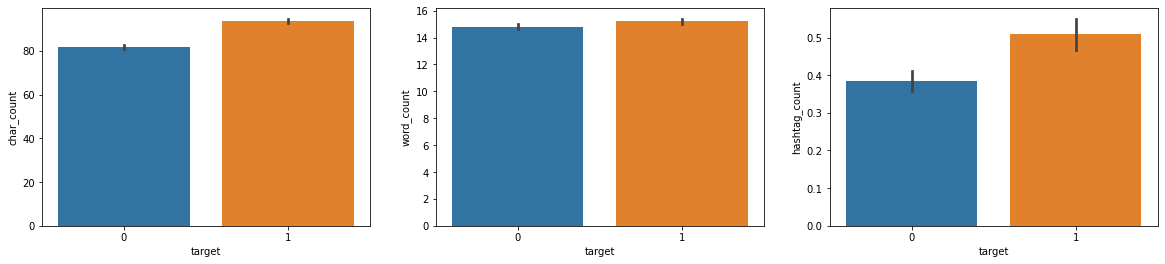

In [18]:
plot_covert_count(train)

In [19]:
# Remove hashtags, mentions and emails
import re
import unicodedata
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stopwords


def remove_emails(x):
     return re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", x)


def remove_urls(x):
    return re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , x)

def remove_rt(x):
    return re.sub(r'\brt\b', '', x).strip()

def remove_special_chars(x):
    x = re.sub(r'[^\w ]+', "", x)
    x = ' '.join(x.split())
    return x


def remove_accented_chars(x):
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return x

def remove_stopwords(x):
    return ' '.join([t for t in x.split() if t not in stopwords])


In [20]:
def remove(df):
    df['text'] = df['text'].apply(lambda x: remove_emails(x))
    df['text'] = df['text'].apply(lambda x: remove_urls(x))
    df['text'] = df['text'].apply(lambda x: remove_rt(x))
    df['text'] = df['text'].apply(lambda x: remove_special_chars(x))
    df['text'] = df['text'].apply(lambda x: remove_accented_chars(x))
    df['text'] = df['text'].apply(lambda x: remove_stopwords(x))


In [68]:
remove(test_2)

In [69]:
test_2.head()

,id,keyword,location,text,char_count,word_count,hashtag_count,mention_count
0,0,,,happened terrible car crash,29,6,0,0
1,2,,,heard earthquake different cities stay safe,56,9,1,0
2,3,,,forest fire spot pond geese fleeing street save,78,19,0,0
3,9,,,apocalypse lighting spokane wildfires,37,4,2,0
4,11,,,typhoon soudelor kills 28 china taiwan,38,8,0,0


In [70]:
test_2['target'] = 0
test_2[['text','target']].to_csv('test_bert.csv',index=False)

In [23]:
# Wordcloud Visualization
from wordcloud import WordCloud
from textblob import TextBlob

def word_cloud(target):
    text = ' '.join(train[train.target==target]['text'])
    word_cloud = WordCloud(max_font_size=100).generate(text)
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.title('Disaster tweets')
    return plt.show()


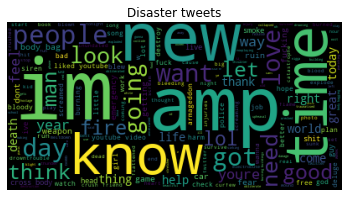

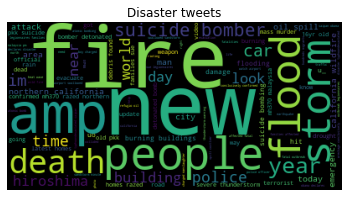

In [24]:
word_cloud(0)
word_cloud(1)

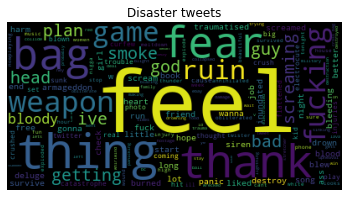

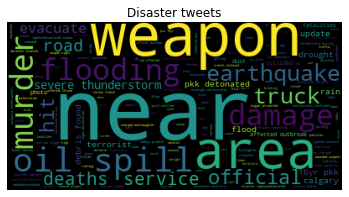

In [25]:
# After removing frequent words
def get_value_counts(df, col):
    text = ' '.join(df[col])
    text = text.split()
    freq = pd.Series(text).value_counts()
    return freq

def remove_common_words(x, freq, n=20):
    fn = freq[:n]
    x = ' '.join([t for t in x.split() if t not in fn])
    return x
freq=get_value_counts(train,'text')
train['text'] = train['text'].apply(lambda x: remove_common_words(x,freq,100))
word_cloud(0)
word_cloud(1)

## BERT


In [33]:
# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [34]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [35]:
train_bert = pd.DataFrame()
valid_bert = pd.DataFrame()
def create_dataset(X,Y,df):
    df['text'] = X
    df['target'] = Y 

In [36]:
X_train, X_valid, y_train, y_valid = train_test_split( train['text'],train['target'], test_size=0.33, random_state=42, stratify=train['target'])
create_dataset(X_train,y_train,train_bert)
create_dataset(X_valid,y_valid,valid_bert)
train_bert.to_csv("train_bert.csv",index=False)
valid_bert.to_csv("valid_bert.csv",index=False)

In [37]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [71]:
# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
# A special token representing an out-of-vocabulary token.
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
train_fields = [ ('text', text_field),('target', label_field)]
test_fields = [ ('text', text_field)]

# TabularDataset

train, valid,test = TabularDataset.splits(path='./', train='train_bert.csv', validation='valid_bert.csv',
                                          test='test_bert.csv', format='CSV', fields=train_fields, skip_header=True)


# Iterators
# sort_key – A key to use for sorting examples in order to batch together examples with similar lengths and minimize padding. 
train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

/opt/conda/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning:

Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.

/opt/conda/lib/python3.7/site-packages/torchtext/data/example.py:68: UserWarning:

Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.

/opt/conda/lib/python3.7/site-packages/torchtext/data/example.py:78: UserWarning:

Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.

/opt/conda/lib/python3.7/site-packages/torchtext/data/iterator.py:48: UserWarning:

BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.

/opt/conda/lib/python3.7/site-packages/torchtext/data/iterator.py:48: UserWarning:

Iterator class will be retired soon and moved t

In [41]:
# Model
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

In [43]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [45]:
# Training Function
destination_folder = './'

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (text_keyword, target), _ in train_loader:
            target = target.type(torch.LongTensor)           
            target = target.to(device)
            text_keyword = text_keyword.type(torch.LongTensor)  
            text_keyword = text_keyword.to(device)
            output = model(text_keyword, target)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (text_keyword,target), _ in valid_loader:
                        target = target.type(torch.LongTensor)           
                        target = target.to(device)
                        text_keyword = text_keyword.type(torch.LongTensor)  
                        text_keyword = text_keyword.to(device)
                        output = model(text_keyword, target)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [46]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model=model, optimizer=optimizer)

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch [1/5], Step [159/1595], Train Loss: 0.5913, Valid Loss: 0.5157
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [1/5], Step [318/1595], Train Loss: 0.5191, Valid Loss: 0.4746
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [2/5], Step [477/1595], Train Loss: 0.4407, Valid Loss: 0.4656
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [2/5], Step [636/1595], Train Loss: 0.4107, Valid Loss: 0.4885
Epoch [3/5], Step [795/1595], Train Loss: 0.3484, Valid Loss: 0.4977
Epoch [3/5], Step [954/1595], Train Loss: 0.3352, Valid Loss: 0.5221
Epoch [4/5], Step [1113/1595], Train Loss: 0.2638, Valid Loss: 0.5754
Epoch [4/5], Step [1272/1595], Train Loss: 0.2472, Valid Loss: 0.6838
Epoch [5/5], Step [1431/1595], Train Loss: 0.1781, Valid Loss: 0.6134
Epoch [5/5], Step [1590/1595], Train Loss: 0.1755, Valid Loss: 0.6375
Model saved to ==> .//metrics.pt
Finished Training!


Model loaded from <== .//metrics.pt


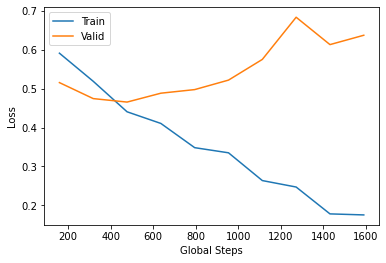

In [47]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [48]:
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== .//model.pt


0.46563752108736883

In [49]:
y_eval = []
y_true_eval = []
def evaluate(model, test_loader):  

    model.eval()
    with torch.no_grad():
        for (text_keyword,target), _ in test_loader:

                target = target.type(torch.LongTensor)           
                target = target.to(device)
                text_keyword = text_keyword.type(torch.LongTensor)  
                text_keyword = text_keyword.to(device)
                output = model(text_keyword, target)

                _, output = output
                y_eval.extend(torch.argmax(output, 1).tolist())
                y_true_eval.extend(target.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true_eval, y_eval, labels=[0,1], digits=4))
    
    cm = confusion_matrix(y_true_eval, y_eval, labels=[0,1])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Not Disaster', 'REAL'])
    ax.yaxis.set_ticklabels(['Not Disaster', 'REAL'])

Classification Report:
              precision    recall  f1-score   support

           0     0.7664    0.9365    0.8430      1433
           1     0.8806    0.6213    0.7286      1080

    accuracy                         0.8010      2513
   macro avg     0.8235    0.7789    0.7858      2513
weighted avg     0.8155    0.8010    0.7938      2513



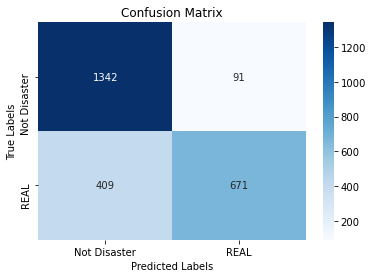

In [50]:
evaluate(best_model, valid_iter)


In [51]:
valid_bert['y_eval'] = y_eval

valid_bert[valid_bert.target ==1]

,text,target,y_eval
6006,agree certain cultural appropriation things ho...,1,0
3063,sure megaquake story brought sense panic quest...,1,0
1505,learning legacy catastrophic eruption newyorker,1,0
494,telnet attacked 1241317240 streamyxhomesouthern,1,0
2717,zayn malik perrie edwards end engagement sheua...,1,0
...,...,...,...
3411,kendall jenner nick jonas dating literally exp...,1,0
5555,major rainstorm happening gonna lie drift away...,1,0
1103,1st august turkish jets bombed village zergele...,1,1
4230,meg issues hazardous weather outlook hwo wx,1,0


In [54]:
y_pred = []
def predict(model, test_loader):    

    model.eval()
    with torch.no_grad():
        for (text,target), _ in test_loader:
                target = target.type(torch.LongTensor)           
                target = target.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(text, target)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())

In [72]:
predict(best_model, test_iter)

/opt/conda/lib/python3.7/site-packages/torchtext/data/batch.py:23: UserWarning:

Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.



In [ ]:
test_final = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
test_final['target'] = y_pred
test_final[['id','target']].to_csv('submission.csv',index=False)